# Exploratory Analysis

**Sample Scenario**

We would like to be able to use attributes of customers to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable.

Our target variable is spending_score.
Currently the only customer data we have available to use in this project is age, annual_income and gender.
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

## Wrangle Data 

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

In [2]:
df = wrangle.get_mall_customers('SELECT * FROM customers')
train, validate, test = wrangle.train_validate_test_split(df)

In [3]:
# reassigned to df for personal preference
df = train

NB. We'll explore unscaled, but scale before modeling.

## Answer Questions

### What is the distribution of each of the variables?

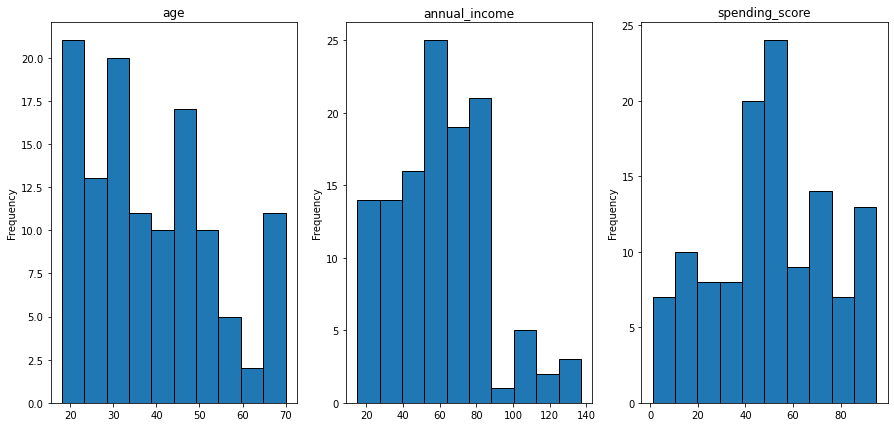

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

<AxesSubplot:>

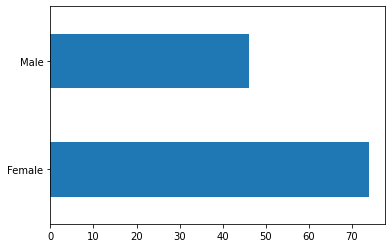

In [5]:
df.gender.value_counts().plot.barh()

**Takeaways:**

- spending score is ~ normal
- age and anuual income have a long tail on the right -- i.e. they are *right skewed*
- more female than male

### Does spending score differ across gender?

1. Viz gender against spending score
1. Stats test to confirm

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

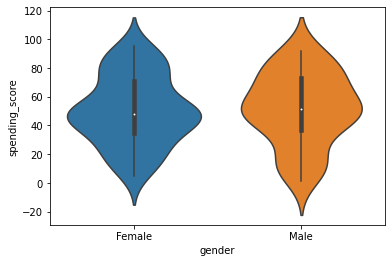

In [7]:
sns.violinplot(data=df, y='spending_score', x='gender')

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

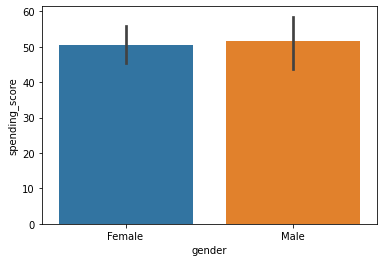

In [9]:
# black bars indicate confidence sample ( where the true value lies)_
sns.barplot(data=df, y='spending_score', x='gender')

Text(0.5, 1.0, 'Is there a difference in spending score for\nmale vs. female customers?')

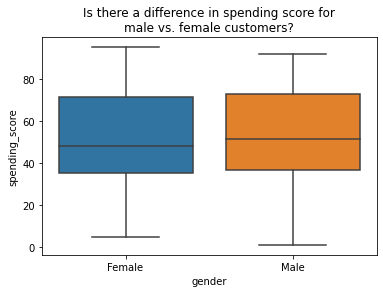

In [6]:
# categorical vs continuous variable (box, violin, bar)
sns.boxplot(data=df, y='spending_score', x='gender')
plt.title("Is there a difference in spending score for\nmale vs. female customers?")

**Takeaways:**

T-test

- one-tailed or two_tailed?
    >Answer: two-tailed b/c we are looking for any difference in means

- one-sample or two-sample?
    >Answer: two-sample b/c we are looking at avg spending score of two separate samples
        - one-sample if we were comparing score of females to total avg spending score

T-test assumes variance is equal

**Levene's Test**: test for equal variance
- $H_{0}$: there is no difference in spending score variance between the two samples
- $H_{a}$: there is a diff in specnding score varaince between the two

In [10]:
stats.levene(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
)

LeveneResult(statistic=0.10928566487557842, pvalue=0.7415451203905439)

A high p-value means we **fail to reject the null hypothesis**
i.e. the variance is about the same

In [11]:
stats.ttest_ind(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
    equal_var=True,
)

Ttest_indResult(statistic=0.24250945188004078, pvalue=0.8088064406384925)

We conclude that there is no significant difference in spending score of females and males (p = .809).

**Conclusion:**

- 

### Is there a relationship between spending score and annual income?

1. Viz annual_income by spending_score
2. Spearman's test if we want to confirm correlation (pearson's assumes normally distributed vars)

<AxesSubplot:title={'center':'Is there a relationship\nbetween annual income and spending score?'}, xlabel='annual_income', ylabel='spending_score'>

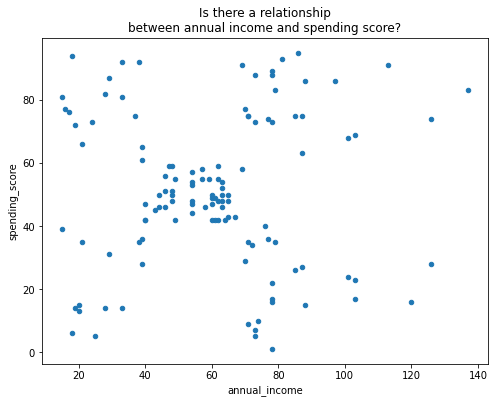

In [12]:
df.plot.scatter(
    x="annual_income",
    y="spending_score",
    title='Is there a relationship\nbetween annual income and spending score?',
    figsize=(8, 6),
)

**Conclusion:**

- not linear relationship
- looks like an 'X'
- loos like there might be clusters, the middle is very dense, the corners dont look as clustered

Is there a relationship between age and spending score?

1. Viz age by spending_score. 
1. Create age bins and compare

<AxesSubplot:title={'center':'Is there a relationship between age and spending score?'}, xlabel='age', ylabel='spending_score'>

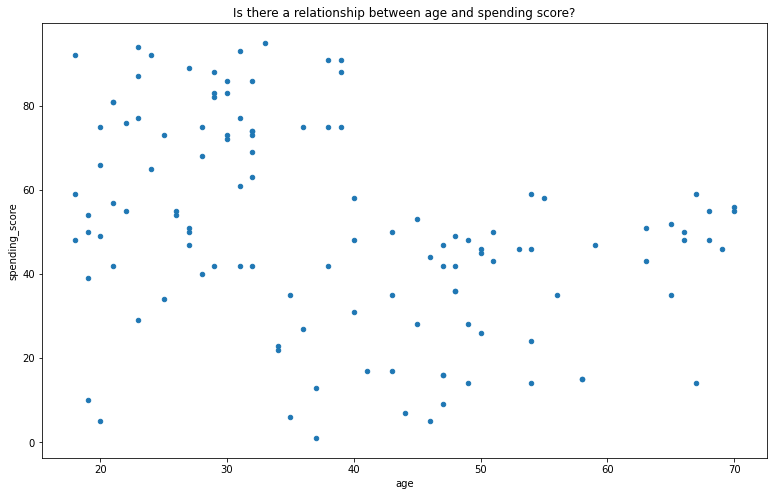

In [13]:
df.plot.scatter(y='spending_score', x='age', title='Is there a relationship between age and spending score?', figsize=(13, 8))

**Takeaways**

- spending score trails off as age increases
- younger customers have higher spedning scores
- after age ~40, max(speding score_ decreases

---

#### pd.cut demo

In [20]:
x = pd.Series(range(1,11))
x

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
dtype: int64

In [21]:
pd.cut(x,[0,7,9,11])

0     (0, 7]
1     (0, 7]
2     (0, 7]
3     (0, 7]
4     (0, 7]
5     (0, 7]
6     (0, 7]
7     (7, 9]
8     (7, 9]
9    (9, 11]
dtype: category
Categories (3, interval[int64]): [(0, 7] < (7, 9] < (9, 11]]

---

In [82]:
df['age_bin'] = pd.cut(df.age, [0, 40, 80])
df.age_bin.dtype, \
df.head()

(CategoricalDtype(categories=[(0, 40], (40, 80]],
 , ordered=True),
              gender  age  annual_income  spending_score   age_bin income_bin
 customer_id                                                                 
 64           Female   54             47              59  (40, 80]   (40, 70]
 49           Female   29             40              42   (0, 40]    (0, 40]
 25           Female   54             28              14  (40, 80]    (0, 40]
 137          Female   44             73               7  (40, 80]  (70, 140]
 177            Male   58             88              15  (40, 80]  (70, 140])

<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

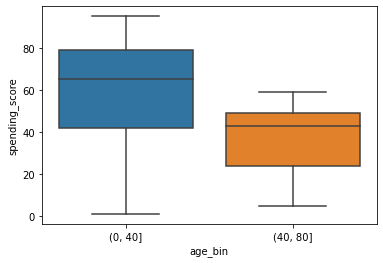

In [23]:
sns.boxplot(data=df, y='spending_score', x='age_bin')

In [25]:
stats.levene(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
)

LeveneResult(statistic=9.154464052447656, pvalue=0.0030460560375097914)

We reject the null hypothesis that the variance in spending sore is the same for folks less than or equal to 40 and above 40

The variance is not equal

**Conclusion:**

In [26]:
stats.ttest_ind(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
    equal_var=False,
)

Ttest_indResult(statistic=6.2431568169013785, pvalue=7.026347337563538e-09)

**Conclusion:**

We reject the null hypothesis that the avg spending score for folks less tan or equal to 40 is the same as the avg spending score for folks over 40.

### If we control for age, does spending score differ across annual income?

1. Viz annual income by spending score for each age bin
2. Analyze each age bin separately

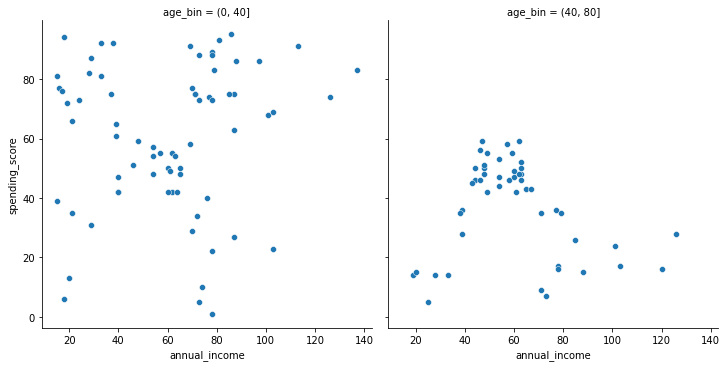

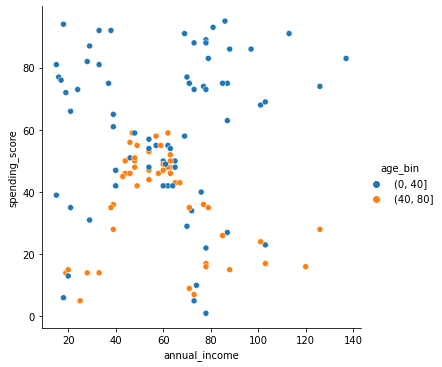

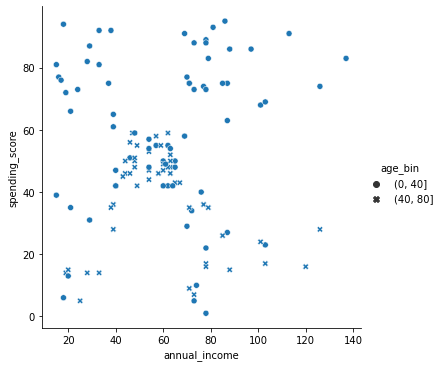

In [32]:
sns.relplot(data=df, y='spending_score', x='annual_income', col='age_bin')
plt.show()
sns.relplot(data=df, y='spending_score', x='annual_income', hue='age_bin')
plt.show()
sns.relplot(data=df, y='spending_score', x='annual_income', style='age_bin')
plt.show()

**Takeaways:**

- 0 thru 40 group still has x-shape
- 40+ crowd is just bottom half of the x

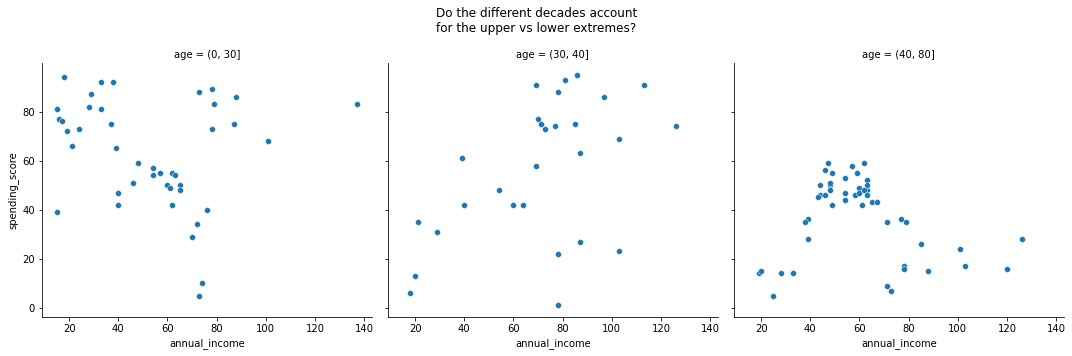

In [33]:
sns.relplot(
    data=df,
    y='spending_score',
    x='annual_income',
    col=pd.cut(df.age, bins=[0, 30, 40, 80]),
)
plt.suptitle("Do the different decades account\nfor the upper vs lower extremes?")
plt.tight_layout()

**Takeaways:**

- 30-40 looks *almost* linear
- 0-30 *almost* looks negative linear
- 40+ looks quadratic

### Does gender explain the high income-low spending score and/or low income-low spending score in the under 40 group?

Text(0.5, 1.0, 'Does gender acccount for upper vs lower\nin the younger age group?')

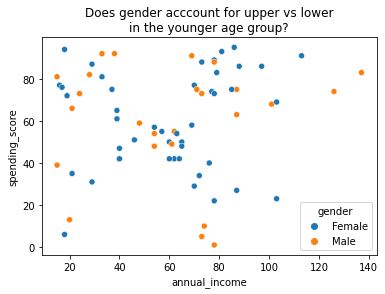

In [34]:
sns.scatterplot(
    x='annual_income',
    y='spending_score',
    data=df[df.age <= 40],
    hue='gender',
)
plt.title("Does gender acccount for upper vs lower\nin the younger age group?")
plt.show()

---

Scatter vs relplot:

- scatter works with axes
- relpot works with figures

- seaborn is b uilt on top of matplotlib
- every matplotlib axis lives within a figure
- a figure can have 1 or more axes in it (2+ is when we have subplots)

---

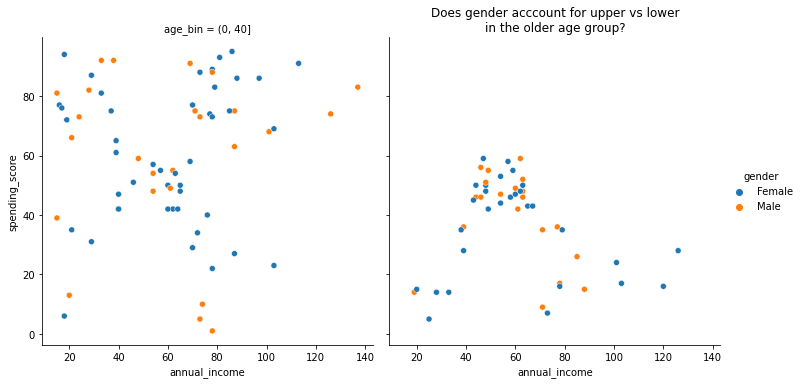

In [37]:
sns.relplot(
    x='annual_income',
    y='spending_score',
    data=df,
    hue='gender',
    col = 'age_bin'
)
plt.title("Does gender acccount for upper vs lower\nin the older age group?")
plt.show()

**Takeaways:**

- gender isn't too informative in this context

In [38]:
df.head()

,gender,age,annual_income,spending_score,age_bin
customer_id,,,,,
64,Female,54,47,59,"(40, 80]"
49,Female,29,40,42,"(0, 40]"
25,Female,54,28,14,"(40, 80]"
137,Female,44,73,7,"(40, 80]"
177,Male,58,88,15,"(40, 80]"


### If we control for annual income, does spending score differ across age?

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\]. 

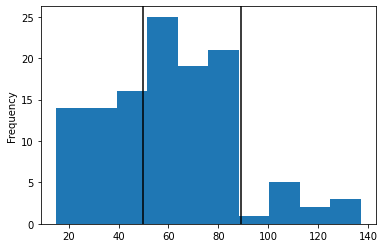

In [57]:
ax = df.annual_income.plot.hist()
ax.axvline(50, color='black')
ax.axvline(89, color='black')

In [75]:
# we create 3 bins based off of distribution
df['income_bin'] = pd.cut(df.annual_income, [0, 40, 70, 140])

In [76]:
df.head()

,gender,age,annual_income,spending_score,age_bin,income_bin
customer_id,,,,,,
64,Female,54,47,59,"(40, 80]","(40, 70]"
49,Female,29,40,42,"(0, 40]","(0, 40]"
25,Female,54,28,14,"(40, 80]","(0, 40]"
137,Female,44,73,7,"(40, 80]","(70, 140]"
177,Male,58,88,15,"(40, 80]","(70, 140]"


<Figure size 1440x720 with 0 Axes>

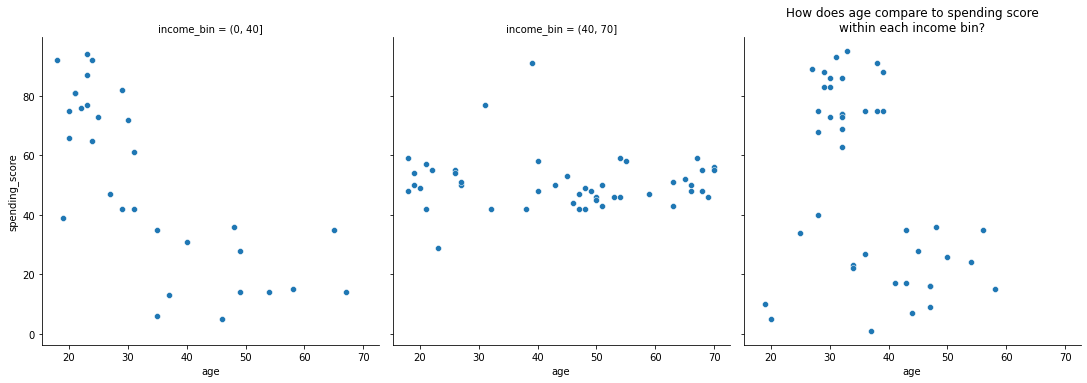

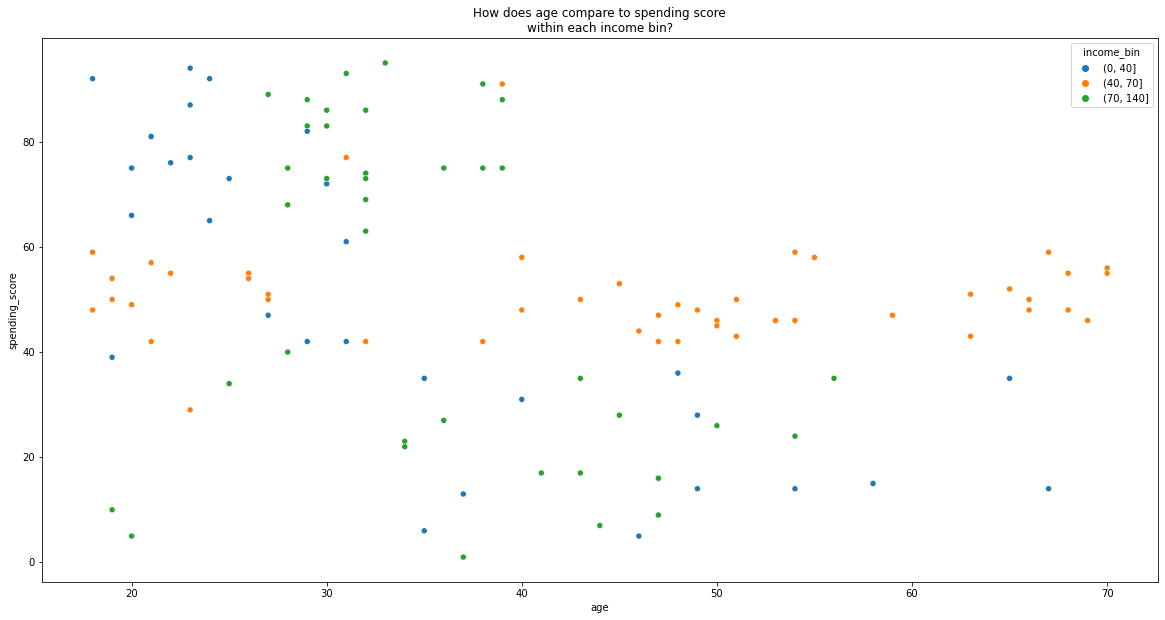

In [80]:
plt.figure(figsize=(20,10))
sns.relplot(
    x='age',
    y='spending_score',
    data=df,
    col='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()
plt.figure(figsize=(20,10))
sns.scatterplot(
    x='age',
    y='spending_score',
    data=df,
    hue='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()

**Takeaways:**

- annual income and spending score are good candidates for clustering
- older folks (40+) tend to not have high values for spending score
- younger folks (30-) with low incomes and high spending scores

## Summary

- annual income and spending score are good candidates for clustering
- older folks (40+) tend to not have high values for spending score
- younger folks (30-) with low incomes and high spending scores
- gender didn't seem to have any significant impact